In [59]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import prepare
import acquire


rng = np.random.RandomState(0)
np.random.seed(123)

In [60]:
df = acquire.get_titanic_data()
df.head()

Reading from csv file...


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [61]:
def prep_titanic(df):
    df = df.drop_duplicates()
    df = df.drop(columns=['deck', 'embarked', 'class', 'age', 'passenger_id','embark_town', 'embarked', 'parch'])
    df[['sex']] = df[['sex']].replace(to_replace="male",value="1")
    df[['sex']] = df[['sex']].replace(to_replace="female",value="0")
    return df

In [62]:
df_prep = prep_titanic(df)
ndf = df_prep.copy(deep = True)
ndf.reindex()


,survived,pclass,sex,sibsp,fare,alone
0,0,3,1,1,7.2500,0
1,1,1,0,1,71.2833,0
2,1,3,0,0,7.9250,1
3,1,1,0,1,53.1000,0
4,0,3,1,0,8.0500,1
...,...,...,...,...,...,...
886,0,2,1,0,13.0000,1
887,1,1,0,0,30.0000,1
888,0,3,0,1,23.4500,0
889,1,1,1,0,30.0000,1


In [63]:
(ndf == 0).sum()


survived    549
pclass        0
sex           0
sibsp       608
fare         15
alone       354
dtype: int64

In [64]:
ndf

,survived,pclass,sex,sibsp,fare,alone
0,0,3,1,1,7.2500,0
1,1,1,0,1,71.2833,0
2,1,3,0,0,7.9250,1
3,1,1,0,1,53.1000,0
4,0,3,1,0,8.0500,1
...,...,...,...,...,...,...
886,0,2,1,0,13.0000,1
887,1,1,0,0,30.0000,1
888,0,3,0,1,23.4500,0
889,1,1,1,0,30.0000,1


In [66]:
def gimmeThemStats(dFrame):
    """
    Description
    ----
    Outputs the general statistical description of the dataframe,
    outputs the correlation heatmap, and outputs a distribution plot.
    
    Parameters
    ----
    dFrame(DataFrame):
        The dataframe for which information will be displayed.
        
    Returns
    ----
    Nothing.
    
    """
    # Description
    print("Descriptive Stats:")
    display(dFrame.describe().T)
    
    # Heatmap
    plt.figure(figsize=(10, 8)) 
    plt.title("Heatmap", fontsize = 'x-large')
    sns.heatmap(dFrame.corr(), annot =True)
    
    # Distribution
    ### NOTE: I changed histplot to distplot
    fig, axes = plt.subplots(4, 2, figsize=(14,14))
    fig.suptitle("Distribution Plot", y=0.92, fontsize='x-large')
    fig.tight_layout(pad=4.0)

    for i,j in enumerate(ndf.columns[:-1]):
        sns.distplot(dFrame[j], ax=axes[i//2, i%2])

Descriptive Stats:


,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.0,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.0,2.0000,3.0000,3.0,3.0000
sibsp,891.0,0.523008,1.102743,0.0,0.0000,0.0000,1.0,8.0000
fare,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
alone,891.0,0.602694,0.489615,0.0,0.0000,1.0000,1.0,1.0000


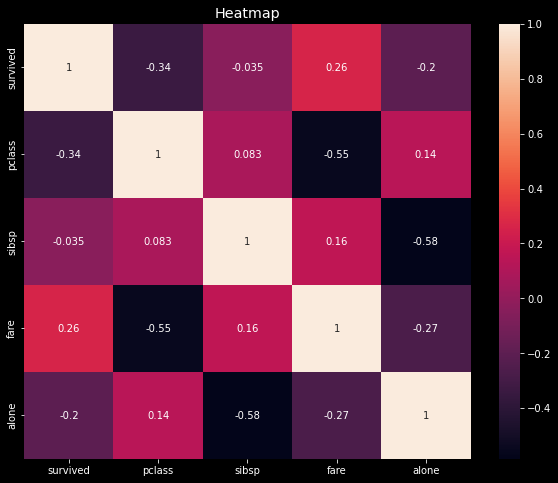

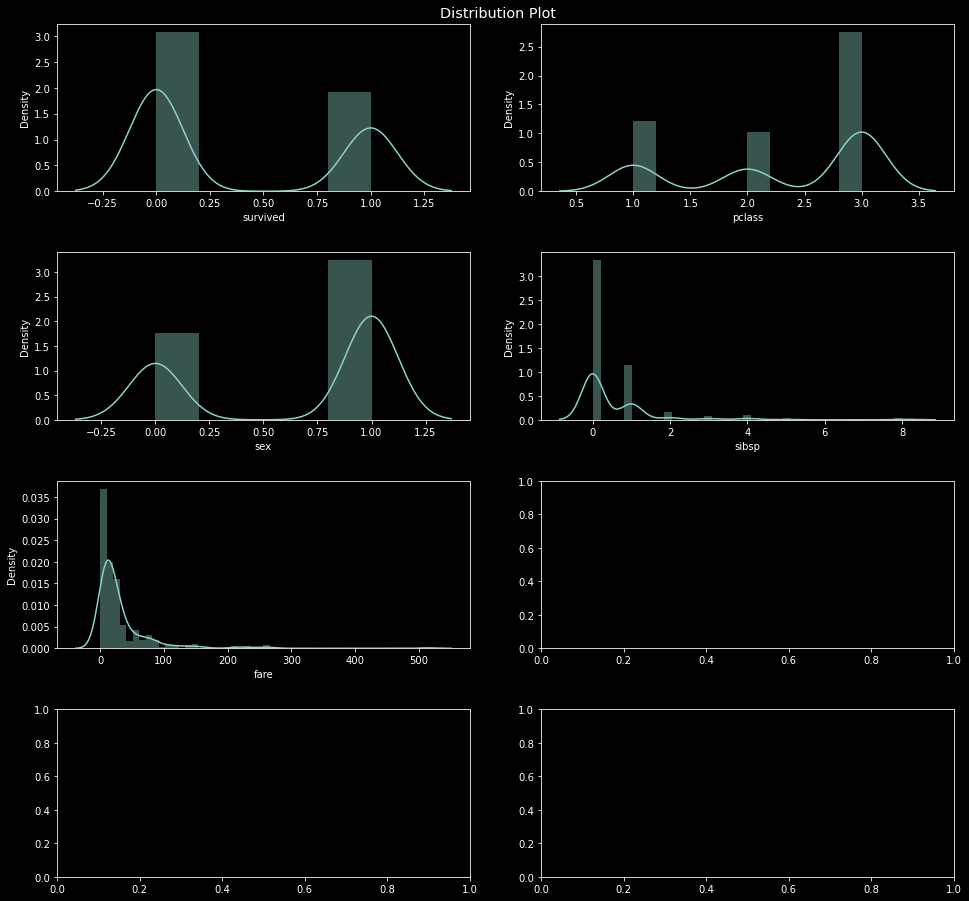

In [67]:
gimmeThemStats(ndf)

In [68]:
dfMeanMed = ndf.copy(deep = True)

In [76]:
dfMeanMed.isna().sum()

survived    0
pclass      0
sex         0
sibsp       0
fare        0
alone       0
dtype: int64

In [77]:
dfMeanMed.kurt() - ndf.kurt()

survived    0.0
pclass      0.0
sex         0.0
sibsp       0.0
fare        0.0
alone       0.0
dtype: float64

In [78]:
dfMeanMed

,survived,pclass,sex,sibsp,fare,alone
0,0,3,1,1,7.2500,0
1,1,1,0,1,71.2833,0
2,1,3,0,0,7.9250,1
3,1,1,0,1,53.1000,0
4,0,3,1,0,8.0500,1
...,...,...,...,...,...,...
886,0,2,1,0,13.0000,1
887,1,1,0,0,30.0000,1
888,0,3,0,1,23.4500,0
889,1,1,1,0,30.0000,1
